Base: C:\Users\riley\PycharmProjects\processamento_imagems
Imgs : 2
Masks: 2
Labelmap carregado:
  background -> (0, 0, 0)
  bridge     -> (184, 61, 245)
  ruler      -> (250, 125, 187)
  water      -> (170, 240, 209)

Visualizando par 1: frame_000000.png


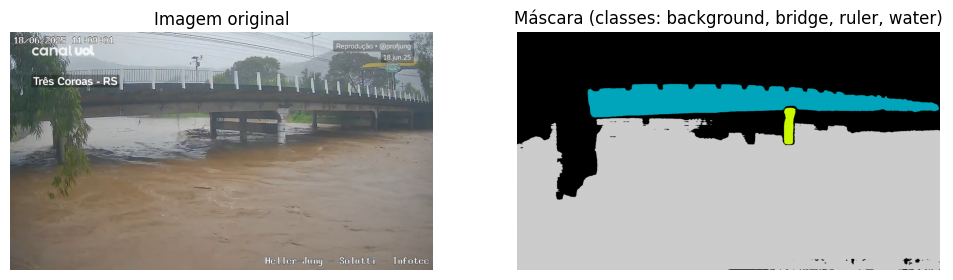


Visualizando par 2: frame_000001.png


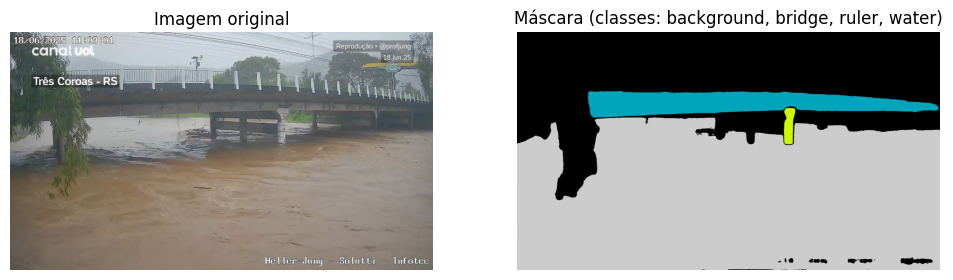

In [7]:
import os
import json
from pathlib import Path

import numpy as np
import cv2
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 6)
plt.rcParams["axes.grid"] = False
SEED = 42
np.random.seed(SEED)

BASE = Path.cwd()
DATASET = BASE / "dataset"
IMG_DIR = DATASET / "img"
MASK_DIR = DATASET / "mask"
LABELMAP_PATH = DATASET / "labelmap.txt"

print("Base:", BASE)
print("Imgs :", len(list(IMG_DIR.glob('*'))))
print("Masks:", len(list(MASK_DIR.glob('*'))))

# ===============================
# Leitura do labelmap
# ===============================
def load_labelmap(labelmap_path: Path):
    labelmap = {}
    with open(labelmap_path, "r", encoding="utf-8") as f:
        for line in f:
            line = line.strip()
            if not line or ":" not in line:
                continue
            name, rest = line.split(":", 1)
            rgb = rest.split(":")[0]
            rgb = rgb.strip()
            if not rgb:
                continue
            try:
                r, g, b = map(int, rgb.split(","))
                labelmap[(r, g, b)] = name.strip()
            except ValueError:
                pass
    return labelmap

# ===============================
# Funções utilitárias
# ===============================
def rgb_mask_to_index(mask_rgb: np.ndarray, labelmap: dict) -> np.ndarray:
    """
    Converte uma máscara RGB (colorida) em matriz de índices de classe.
    Cada pixel RGB é comparado com o dicionário labelmap.
    """
    h, w, _ = mask_rgb.shape
    mask_index = np.zeros((h, w), dtype=np.uint8)
    for i, (rgb, name) in enumerate(labelmap.items()):
        color = np.array(rgb, dtype=np.uint8)
        match = np.all(mask_rgb == color, axis=-1)
        mask_index[match] = i
    return mask_index

def show_image_and_mask(img_path: Path, mask_path: Path, labelmap: dict):
    img = cv2.imread(str(img_path))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    mask_rgb = cv2.imread(str(mask_path))
    mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB)
    mask_index = rgb_mask_to_index(mask_rgb, labelmap)

    unique_vals = np.unique(mask_index)
    colors = np.array(list(labelmap.keys())) / 255.0
    names = list(labelmap.values())

    # Visualização
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title("Imagem original")
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.imshow(mask_index, cmap="nipy_spectral")
    plt.title(f"Máscara (classes: {', '.join([names[i] for i in unique_vals])})")
    plt.axis("off")
    plt.show()

# ===============================
# Visualização das duas primeiras
# ===============================
all_imgs = sorted(IMG_DIR.glob("*.png"))
all_masks = sorted(MASK_DIR.glob("*.png"))

# --- carregar o labelmap antes de usar ---
labelmap = load_labelmap(LABELMAP_PATH)
print("Labelmap carregado:")
for rgb, name in labelmap.items():
    print(f"  {name:<10} -> {rgb}")


if len(all_imgs) >= 2 and len(all_masks) >= 2:
    for i in range(2):
        print(f"\nVisualizando par {i+1}: {all_imgs[i].name}")
        show_image_and_mask(all_imgs[i], all_masks[i], labelmap)
else:
    print("Verifique se existem pelo menos 2 imagens e 2 máscaras nas pastas correspondentes.")


Dataset carregado:
  X shape: (2, 256, 256, 3), dtype=float32
  y shape: (2, 256, 256), dtype=uint8
  Train: 1, Val: 1


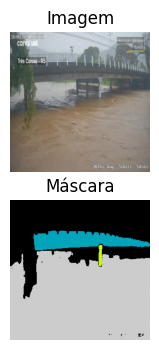

In [8]:
from sklearn.model_selection import train_test_split

IMG_SIZE = (256, 256)
TEST_RATIO = 0.2

def load_dataset(img_dir: Path, mask_dir: Path, labelmap: dict, target_size=(256, 256)):
    imgs, masks = [], []
    color_to_idx = {rgb: i for i, rgb in enumerate(labelmap.keys())}

    img_paths = sorted(img_dir.glob("*.png"))
    for img_path in img_paths:
        mask_path = mask_dir / img_path.name
        if not mask_path.exists():
            continue

        img = cv2.imread(str(img_path))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32) / 255.0

        mask_rgb = cv2.imread(str(mask_path))
        mask_rgb = cv2.cvtColor(mask_rgb, cv2.COLOR_BGR2RGB)
        mask_rgb = cv2.resize(mask_rgb, target_size, interpolation=cv2.INTER_NEAREST)

        mask_idx = np.zeros(target_size, dtype=np.uint8)
        for i, (rgb, _) in enumerate(labelmap.items()):
            match = np.all(mask_rgb == np.array(rgb, dtype=np.uint8), axis=-1)
            mask_idx[match] = i

        imgs.append(img)
        masks.append(mask_idx)

    X = np.stack(imgs, axis=0)
    y = np.stack(masks, axis=0)
    return X, y

X, y = load_dataset(IMG_DIR, MASK_DIR, labelmap, IMG_SIZE)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=TEST_RATIO, random_state=SEED)

print(f"Dataset carregado:")
print(f"  X shape: {X.shape}, dtype={X.dtype}")
print(f"  y shape: {y.shape}, dtype={y.dtype}")
print(f"  Train: {len(X_train)}, Val: {len(X_val)}")

def plot_samples(X, y, n=3):
    n = min(n, len(X))
    plt.figure(figsize=(12, 4))
    for i in range(n):
        plt.subplot(2, n, i + 1)
        plt.imshow(X[i])
        plt.axis("off")
        if i == 0:
            plt.title("Imagem")

        plt.subplot(2, n, n + i + 1)
        plt.imshow(y[i], cmap="nipy_spectral")
        plt.axis("off")
        if i == 0:
            plt.title("Máscara")
    plt.show()

plot_samples(X_train, y_train, n=2)


In [ ]:

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

NUM_CLASSES = len(labelmap)          # background, bridge, water, ruler
INPUT_SHAPE = (IMG_SIZE[0], IMG_SIZE[1], 3)

def conv_block(x, filters):
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.BatchNormalization()(x)
    return x

def unet_small(input_shape, num_classes):
    inputs = layers.Input(shape=input_shape)

    # Encoder
    c1 = conv_block(inputs, 32); p1 = layers.MaxPooling2D()(c1)
    c2 = conv_block(p1, 64);     p2 = layers.MaxPooling2D()(c2)
    c3 = conv_block(p2, 128);    p3 = layers.MaxPooling2D()(c3)

    # Bottleneck
    bn = conv_block(p3, 256)

    # Decoder
    u3 = layers.UpSampling2D()(bn); u3 = layers.Concatenate()([u3, c3]); c4 = conv_block(u3, 128)
    u2 = layers.UpSampling2D()(c4); u2 = layers.Concatenate()([u2, c2]); c5 = conv_block(u2, 64)
    u1 = layers.UpSampling2D()(c5); u1 = layers.Concatenate()([u1, c1]); c6 = conv_block(u1, 32)

    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(c6)
    return keras.Model(inputs, outputs)

model = unet_small(INPUT_SHAPE, NUM_CLASSES)
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)
model.summary()

# Datasets para o Keras (y precisa shape (H,W,1) para SparseCategoricalCrossentropy)
y_train_exp = y_train[..., np.newaxis]
y_val_exp   = y_val[..., np.newaxis]

callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train_exp,
    validation_data=(X_val, y_val_exp),
    epochs=100,               # com 2 amostras, vai overfitar rápido; early stopping segura
    batch_size=1,
    verbose=1,
    callbacks=callbacks
)

# Predição de inspeção
def visualize_pred(img, mask_true, mask_pred_idx, names=None):
    plt.figure(figsize=(14,4))
    plt.subplot(1,3,1); plt.imshow(img); plt.title("Imagem"); plt.axis("off")
    plt.subplot(1,3,2); plt.imshow(mask_true, cmap="nipy_spectral");
    t = "GT"
    if names is not None:
        uniques = np.unique(mask_true); t += " (" + ", ".join([names[i] for i in uniques]) + ")"
    plt.title(t); plt.axis("off")
    plt.subplot(1,3,3); plt.imshow(mask_pred_idx, cmap="nipy_spectral");
    t = "Pred"
    if names is not None:
        uniques = np.unique(mask_pred_idx); t += " (" + ", ".join([names[i] for i in uniques]) + ")"
    plt.title(t); plt.axis("off")
    plt.show()

# Faz uma predição no primeiro item do conjunto de validação
names = list(labelmap.values())
pred = model.predict(X_val[:1])[0]            # (H,W,C)
pred_idx = np.argmax(pred, axis=-1)           # (H,W)

visualize_pred(X_val[0], y_val[0], pred_idx, names=names)

# Métrica simples de IoU por classe (apenas para referência rápida)
def iou_per_class(y_true, y_pred, num_classes):
    ious = []
    for c in range(num_classes):
        t = (y_true == c)
        p = (y_pred == c)
        inter = np.logical_and(t, p).sum()
        union = np.logical_or(t, p).sum()
        iou = inter / (union + 1e-9)
        ious.append(iou)
    return ious

ious = iou_per_class(y_val[0], pred_idx, NUM_CLASSES)
print("IoU por classe:", {names[i]: float(ious[i]) for i in range(NUM_CLASSES)})

# Salvar pesos (opcional)
model.save("unet_small_segmentation.keras")
print("Modelo salvo em unet_small_segmentation.keras")
